# The NYU finger robot

The robot is constituted of 4 rigid bodies together 3 joints. There is one motor per joint and we can send a desired torque to each motor and read the position (angle) and velocity of each joint using the position sensor attached on each motor (the internal software computes the velocities using finite differences).

<img src="images/finger_edu_1.jpg" width=600>

More details on the robot are avaiable [here](https://github.com/open-dynamic-robot-initiative/open_robot_actuator_hardware/blob/master/mechanics/finger_edu_v1/README.md#fingeredu-v1)


# Mujoco - a robot simulator

[Mujoco](https://mujoco.org/) is a "rigid body dynamics" simulator, it means that it can simulate any articulated, rigid, robot. For example our NYU finger but also more complex robots, such as a humanoid, a quadruped or a hand. It can also simulate other objects and several robots at the same time.

## How does it work?

In a nutshell, every simulator functions as follows:
* First a description of the objects and robots to simulate are given, including their dynamic properties (masses, center of mass), their "boundaries" (to detect collisions between objects) and graphic files to visualize the robot. The visualization is often different than what is simulated (i.e. we often simplify the geometry of the robot, e.g. using cylinders, for the simulation but display all the details in the visualization)

* At each instant of time, the simulator keeps track of all the collisions between all the objects, to know where to compute contact forces. Typically the collisions are simplified to make the simulation fast enough.

* The simulator then computes all the forces exerted on all the objects and robots (e.g. gravity, contact between objects, etc) and uses Netwon's law of motion to compute the next position and velocity of all the objects.

<img src="images/simulation_loop.jpg" width=400>


The user can then decide to apply forces/torques on certain joints, like a motor would do and read all the available information from the simulator to emulate real sensors.

As a user, we then need to write a "controller" that decides what to do at each simulation step.


## Working with the real robot
Each robot has different interfaces to be able to read its sensors and send control commands, which can be different from the robot simulator code. For this laboratory, we have wrapped all the functionality needed from PyBullet into the class NYUFingerSimulator located in the file [nyu_finger_simulator.py](./nyu_finger_simulator.py) which also contains the same functions to control the real robot. Therefore, the controllers you write will work both in the simulator and the real robot.

We detail below the typical control loop we will use throughout the class.

# Typical control loops with sensors and actuators

We discuss in this section how we can make the robot move by sending motor commands.

Every robot comes with a set of actuators that need to be controlled. Typically, a set of "low-level" controllers are available such that one can send a desired motor torque or a desired joint position and the robot controller will transform this into a current to modulate the rotation of an electric motor or the opening/closing of a pneumatic or hydraulic valve. This in turn will create a movement of the robot.

In our class, we will assume that we can send a desired joint torque and that it will be achieved on the robot. PyBullet enables the same level of "abstraction" which is sufficient for most robot applications.

We will now see how we can send desired motor torques to the robot.

## A typical control loop

Here is a typical control loop (what you need to design to control a robot):
1. First read the sensors
2. Compute the desired torque commands
3. Send the commands to the motors
4. Repeat periodically (typically at a rate of ~100Hz to 1KHz)

The example was doing "open loop" control because we did not use the sensor measurement to compute the desired commands. "Closed loop" control will make use of the sensors to compute the control commands.

<img src="images/control_loop.png" width=600>

# Let's Try It!

First import some libraries we need for this lab:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
np.set_printoptions(precision=3) #Limit the print precision to 3 digits
np.set_printoptions(suppress=True) # Disable scientifi number notation when printing numpy arrays

## Simulation

Before going to the real robot, let's familiarize ourselves with the robot in the class through its simulated model. We need to import the class the encapsulates the Mujoco simulator code into a simple to use robot object. Instantiate the simulated robot as follows:

**Important:** If you are running the notebook in Docker, make sure you that you have executed `xhost +` command in the terminal of your Ubuntu computer.

In [2]:
from NYUFinger.sim import NYUFingerSimulator
robot_sim = NYUFingerSimulator()

RuntimeError: `launch_passive` requires that the Python script be run under `mjpython` on macOS

You should see the simulator window pop up like this:

<p align="center">
<img src="images/simulator.png" width=800>
</p>



### Play With The Robot

There are two main functions in the `robot_sim` robot class that you use to control interact with the robot:

- `robot_sim.get_state()`: This function returns the current joint poisition (q) and joint velocity (dq) as a tuple (q, dq) where q, dq are numpy arrays with shape `(3,)` (3=number of joint sensors)
- `robot_sim.set_joint_torque(torque)`: This function sends the joint torque command that the motors on the robot should produce on each link. `torque` is a numpy array with shape `(3,)` (3=number of joint actuators)

Let's make sure we can read the sensors first:

In [ ]:
print('g')
q, dq = robot_sim.get_state()
print('Joint Position:')
print(q)
print('Joint Velocity:')
print(dq)

Now that you can read the joint states of the robot, let's send a zero torque command to it and interact with the robot in the simulator. After running the cell below, go to the simulator window and double cick on one of the robot links. This should highlight that link. Then hold the `ctrl` key on the keyboard and push the robot by holding the right click and dragging. As you do so, the joint poisition and velocities are printed here:

In [ ]:
start_time = time.time()
while time.time()-start_time <120:
    robot_sim.send_joint_torque(np.zeros(3)) # send a zero torque command to the robot
    q, dq = robot_sim.get_state()
    print(f'q: {q} dq:{dq}')
    time.sleep(0.1)

### Reading The Sensors and Commanding The Actuators
Controlling any robotic system involves doing three things over and over again: reads robot sensors -> do some computation -> send torque command to the actuators -> repeat. We call this a control look and we show how it's implemented in the following cell:

In [ ]:
# we can now send a desired motor command and simulate the behavior of the robot
# we send 0.1Nm on the first joint
# we also record the measured state of the robot

# below is a sample code to run the simulation / collect sensor and command data

run_time = 5 # Duration of the experiment in seconds. Feel free to change it
dt = 0.01 # How frequently you run the control. Here we are running it at 100Hz (100 times per second).

## Let's make sure lists so we can record the state of our robot and plot it later
measured_positions = []
measured_velocities = []
desired_torques = []
timestamps = []

# Record the initla state of the robot:
q, dq = robot_sim.get_state()
q0 = q.copy()
dq0 = dq.copy()

start_time = time.time()
while time.time()-start_time < run_time: # Keep running untill run_time seconds is passed since when we started the cell.
    time_now = time.time()

    # we read the position and velocities of the joints from the robot or simulation
    q, dq = robot_sim.get_state()
    
    # we compute the desired torques
    # here we send a constant torque to each joint. You should add your own code here to compute it based on the PD control rule.
    joint_torques = np.array([0.,0.,0.])

    desired_torques.append(joint_torques.copy())
    # we send them to the robot
    robot_sim.send_joint_torque(joint_torques)

    # we store these values for later use. use .copy() to make sure we sure a copy of state is stored.
    measured_positions.append(q.copy()) 
    measured_velocities.append(dq.copy())
    timestamps.append(time_now)

    #Wait for the dt deadile to pass before going back and repating everything
    while time.time()-time_now < dt:
        time.sleep(0.0001)

## Plotting data after the simulation
we stored some data (joint angles and time) while the control loop was running above
Here is an example of plots we can generate with this data.
You can of course generate any types of plot relevant to your problem.

In [ ]:
measured_positions = np.vstack(measured_positions)
measured_velocities = np.vstack(measured_velocities)
desired_torques = np.vstack(desired_torques)
timestamps = np.array(timestamps)

In [ ]:
# we plot the measured position and velocities of all the joints
joint_names = ["HAA", "HFE", "KFE"]

# plot the positions
plt.figure(figsize=[6, 12])
plt.title('joint positions')
for i in range(3):
    plt.subplot(3,1,i+1)
    plt.plot(timestamps, measured_positions[:,i])
    plt.ylabel(joint_names[i] + ' [rad]')
plt.xlabel('Time[s]')


# plot the velocities
plt.figure(figsize=[6, 12])
plt.title('joint velocities')
for i in range(3):
    plt.subplot(3,1,i+1)
    plt.plot(timestamps, measured_velocities[:,i])
    plt.ylabel(joint_names[i] + ' [rad/s]')
plt.xlabel('Time[s]')

### Questions:
(submit a pdf with detailed answers to these questions, including the plots through Brightspace)
1. What is the control rate that we used in this example in Hz?

2. The code sends 0 Nm to all the joints. Locate in the code the place where sensors are read from the robot and commands are sent to the robot. What sensors are read? What type of commands are sent?
  
3. Run the code and plot the joint positions and velocities. What did you observe? Why?

4. Run the same code on the real robot. Move the robot (carefully) and plot the joint positions and velocities. Do the plot correspond to the motion you performed?

5. Perform the same experiment (simulation + real robot) but now send 0.2 Nm to the second joint.

## Real Robot

Now that you know what to do and learned how to control the robot in simultion, let's make it real and try the same on the real robot. 

**Important:** Make sure you reset the notebook kernel before continuing so that nothing you did previously is mixed up with what you will do next. 

Make sure the robot is powered on and connected to your PC. Then run the following cell to make an object that talks with it:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
np.set_printoptions(precision=3) #Limit the print precision to 3 digits
np.set_printoptions(suppress=True) # Disable scientifi number notation when printing numpy arrays
from NYUFinger.real import NYUFingerHardware

robot_real = NYUFingerHardware()

If above didn't run successfully, call a TA. Otherwise, you should be able to read the sensors on the robot like this:

In [ ]:
q, dq = robot_real.get_state()
assert q is not None, 'The robot did not send its state to the PC. Ask a TA for help.'
print('Joint Position:')
print(q)
print('Joint Velocity:')
print(dq)

Our real robot has can sense how much each joint has moved since it's turned on but it has no idea what the absolute value of the joint angles are. In other words, the robot has no way of knowing how it looked before waking up! Here we need to put the robot in a known configuration and let it know. After this, the robot will be able to keep track of its joint configurations. 

First, carefully move the robot's joints so that it looks like the following picture:

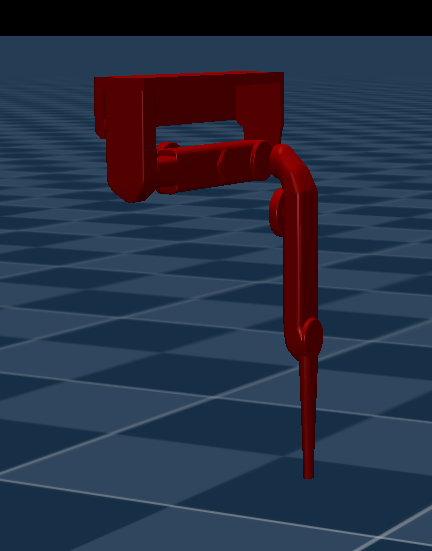

Now, while carefully holding the robot, run the following cell to reset the joint sensors and call a TA if you see an error. 

In [ ]:
robot_real.reset_sensors()

To make sure we did the job right, let's visualize the numbers it returns using its 3D model and compare how it think it looks to what it really looks in reality. First, make a visualizer object:

In [ ]:
from NYUFinger.utils.vis import NYUFingerVisualizer
visulizer = NYUFingerVisualizer()

Now we continiously read the real robot's state and send it to the visualizer in a loop. If everyhing is working right, you should see the robot in visualizer move and look the same way as the real robot:

In [ ]:
start_time = time.time()
while time.time()-start_time < 30:
    q, dq = robot_real.get_state()
    visulizer.show(q)
    time.sleep(0.02)

If everything looks right, you're ready to try the control loop for the real robot:

In [ ]:
# we can now send a desired motor command and simulate the behavior of the robot
# we send 0.1Nm on the first joint
# we also record the measured state of the robot

# below is a sample code to run the simulation / collect sensor and command data

run_time = 5 # Duration of the experiment in seconds. Feel free to change it
dt = 0.01 # How frequently you run the control. Here we are running it at 100Hz (100 times per second).

## Let's make sure lists so we can record the state of our robot and plot it later
measured_positions = []
measured_velocities = []
desired_torques = []
timestamps = []

# Record the initla state of the robot:
q, dq = robot_real.get_state()
q0 = q.copy()
dq0 = dq.copy()

start_time = time.time()
while time.time()-start_time < run_time: # Keep running untill run_time seconds is passed since when we started the cell.
    time_now = time.time()

    # we read the position and velocities of the joints from the robot or simulation
    q, dq = robot_real.get_state()
    
    # we compute the desired torques
    # here we send a constant torque to each joint. You should add your own code here to compute it based on the PD control rule.
    joint_torques = np.array([0.1,0.,0.])

    desired_torques.append(joint_torques)
    # we send them to the robot
    robot_real.send_joint_torque(joint_torques.copy())

    # we store these values for later use. use .copy() to make sure we sure a copy of state is stored.
    measured_positions.append(q.copy()) 
    measured_velocities.append(dq.copy())
    timestamps.append(time_now)

    #Wait for the dt deadile to pass before going back and repating everything
    while time.time()-time_now < dt:
        time.sleep(0.0001)